## A fastai implementation of a X-Ray pneumonia detector

Essential notebook initialization code for automatic library reload

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing all necessary packages

In [55]:
from fastai import *
from fastai.vision import *
from fastai.imports import *

import numpy as np 
import pandas as pd 

import os

In [28]:
data_path = Path('../input/chest_xray/chest_xray')
data_path

PosixPath('../input/chest_xray/chest_xray')

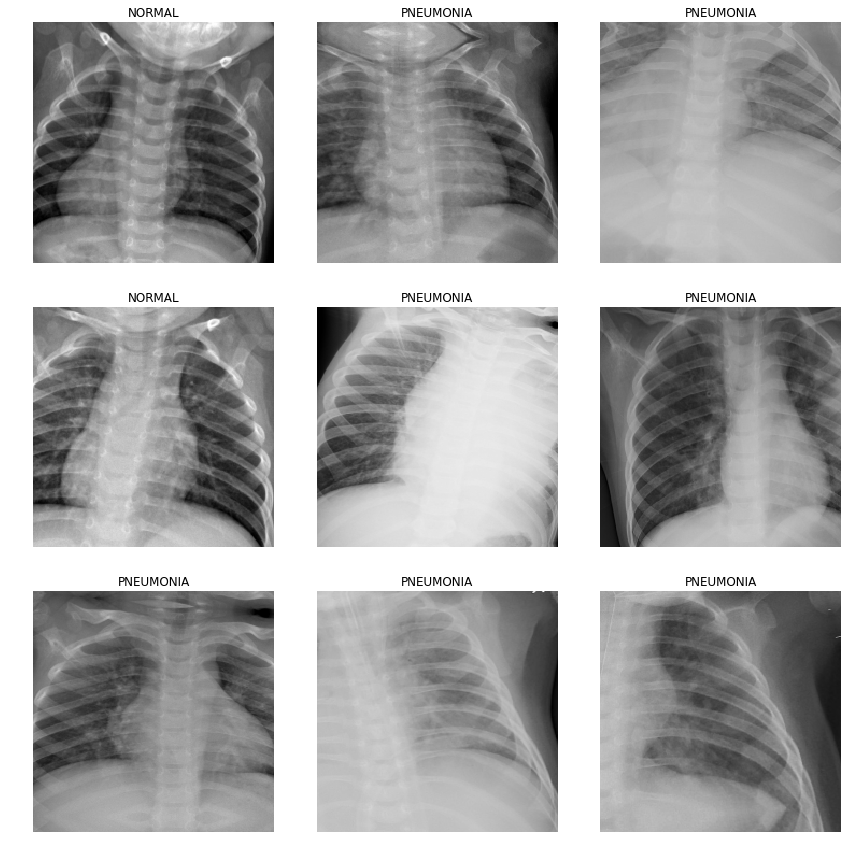

In [30]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path=data_path,
                                  train='train',
                                  valid='val',
                                  test='test',
                                  size=224,
                                  bs=64,
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms())
data.normalize(imagenet_stats)
data.show_batch(rows=3)

### Training phase

We are going to use resnet101, feel free to use other models, you can find fastai supported models here docs.fast.ai/vision.models.html

In [32]:
learner = cnn_learner(data=data,
                      base_arch=models.resnet101,
                      metrics=accuracy,
                      model_dir="/tmp/model/")

In [33]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.320594,0.187449,0.940222,03:39
1,0.201223,0.134985,0.953032,03:39
2,0.147466,0.130010,0.953886,03:39
3,0.127136,0.120960,0.953886,03:38


In [34]:
# interpret the results
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

In [35]:
len(data.valid_ds)==len(losses)==len(idxs)

True

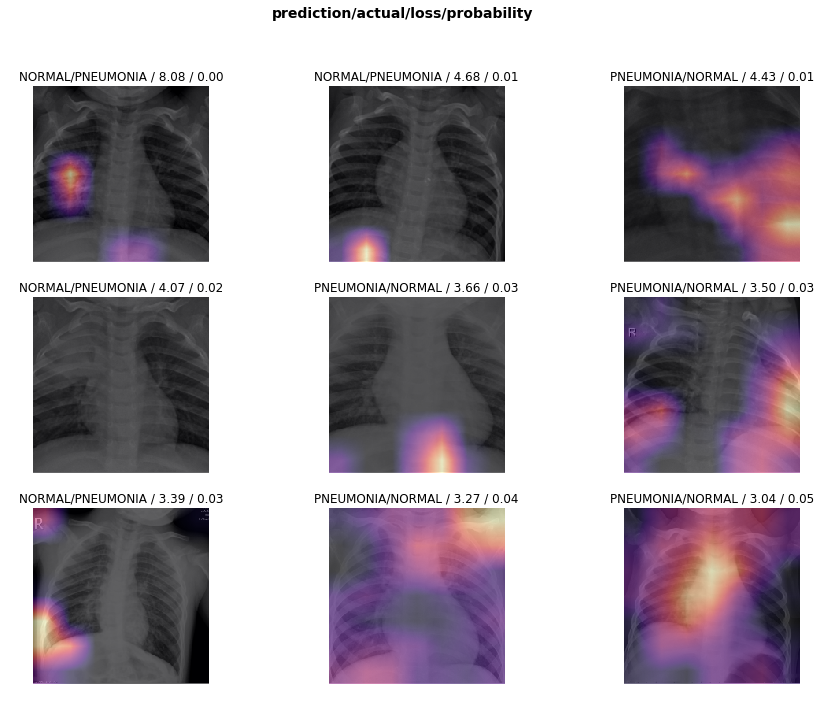

In [36]:
# plot the top losses
interp.plot_top_losses(9, figsize=(15,11))

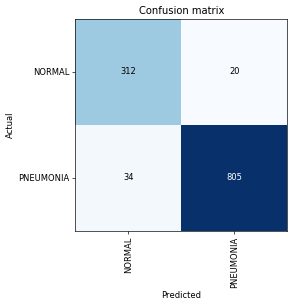

In [37]:
# plot the confusion matrix
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [38]:
learner.save('stage-1')

Unfreez the network so we'll train on the entire model

In [39]:
#So until now, we have only been training the last classification layers, but what if we want to optimize earlier layers too
# In transfer learning, tweaking initial layers should be done with caution, and the learning rate should be kept pretty low
learner.unfreeze()

In [40]:
learner.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


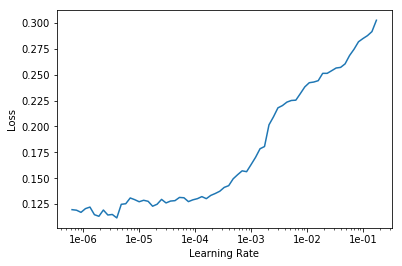

In [41]:
#The lr_find function runs the model for a subset of data at multiple learning rate to determine which learning rate would be best
learner.lr_find()
learner.recorder.plot()

In [42]:
learner.fit_one_cycle(10, max_lr=slice(1e-6, 1e-5))


epoch,train_loss,valid_loss,accuracy,time
0,0.125257,0.117457,0.955594,03:43
1,0.118774,0.124967,0.955594,03:42
2,0.111019,0.114654,0.959863,03:45
3,0.105869,0.109806,0.963279,03:45
4,0.100341,0.113346,0.959863,03:44
5,0.100329,0.099787,0.965841,03:44
6,0.095802,0.097899,0.965841,03:44
7,0.092680,0.097520,0.967549,03:43
8,0.092751,0.100396,0.964133,03:42
9,0.084900,0.095774,0.970111,03:43


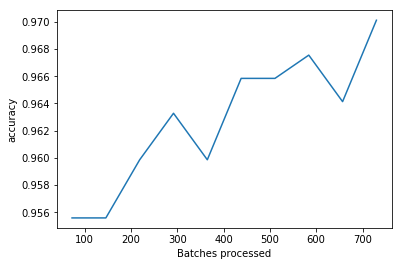

In [43]:
learner.recorder.plot_metrics()

In [44]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

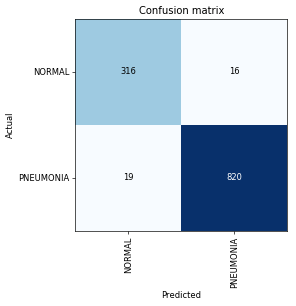

In [47]:
cm=interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [59]:
cm=interp.confusion_matrix()

In [2]:
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp + tn)/(tp + tn + fp + fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

F1= 2*(recall * precision) / (recall + precision)
print("F1 score of the model is {:.2f}".format(F1))
print("Accuracy of the model is {:.2f}".format(accuracy))


Recall of the model is 0.98
Precision of the model is 0.98
F1 score of the model is 0.98
Accuracy of the model is 0.97
